<a href="https://colab.research.google.com/github/fbeilstein/dbms/blob/master/DB_lecture_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Concurrency Control**


We mentioned that the transaction manager and lock manager work together to handle **concurrency control**. **Concurrency control** is a set of techniques for handling interactions between concurrently executing transactions. These techniques can be roughly grouped into the following categories:
* **Optimistic concurrency control (OCC)**
Allows transactions to execute concurrent read and write operations, and determines whether or not the result of the combined execution is serializable. In other words, transactions do not block each other, maintain histories of their operations, and check these histories for possible conflicts before commit. If execution results in a conflict, one of the conflicting transactions is aborted.
* **Multiversion concurrency control (MVCC)**
Guarantees a consistent view of the database at some point in the past identified by the timestamp by allowing multiple timestamped versions of the record to be present. MVCC can be implemented using validation techniques, allowing only one of the updating or committing transactions to win, as well as with lockless techniques such as timestamp ordering, or lock-based ones, such as two-phase locking.
* **Pessimistic (also known as conservative) concurrency control (PCC)**
There are both lock-based and nonlocking conservative methods, which differ in
how they manage and grant access to shared resources. Lock-based approaches
require transactions to maintain locks on database records to prevent other
transactions from modifying locked records and assessing records that are being
modified until the transaction releases its locks. Nonlocking approaches maintain read and write operation lists and restrict execution, depending on the schedule of unfinished transactions. Pessimistic schedules can result in a deadlock when multiple transactions wait for each other to release a lock in order to proceed.


We will concentrate on node-local concurrency control techniques. Before we can further discuss concurrency control, we need to define a set of problems we’re trying to solve and discuss how transaction operations overlap and what
consequences this overlapping has.

**Serializability**


**Transactions** consist of read and write operations executed against the database state, and business logic (transformations, applied to the read contents). A **schedule** is a list of operations required to execute a set of transactions from the database-system perspective (i.e., only ones that interact with the database state, such as 
* read, 
* write, 
* commit, or 
* abort 

operations), since all other operations are assumed to be side-effect free (in other words, have no impact on the database state).

A schedule is **complete** if contains all operations from every transaction executed in it. 

Correct schedules are logical equivalents to the original lists of operations, but their parts can be executed in parallel or get reordered for optimization purposes, as long as this does not violate ACID properties and the correctness of the results of individual transactions.

A schedule is said to be **serial** when transactions in it are executed completely independently and without any interleaving: every preceding transaction is **fully executed** before the next one starts. Serial execution is easy to reason about, as contrasted with all possible interleavings between several multistep transactions. However, always executing transactions one after another would significantly limit the system throughput and hurt performance.

We need to find a way to execute transaction operations concurrently, while maintaining the correctness and simplicity of a serial schedule. We can achieve this with **serializable schedules**. A schedule is **serializable** if it is equivalent to some complete serial schedule over the same set of transactions. In other words, it produces the same result as if we executed a set of transactions one after another in some order.


**Transaction Isolation**

Transactional database systems allow different **isolation levels**. An **isolation level** specifies how and when parts of the transaction can and should become visible to other transactions. In other words, isolation levels describe the degree to which transactions are isolated from other concurrently executing transactions, and what kinds of anomalies can be encountered during execution.

Achieving isolation comes at a cost: to prevent incomplete or temporary writes from propagating over transaction boundaries, we need additional coordination and synchronization, which negatively impacts the performance.

**Read and Write Anomalies**


The SQL standard refers to and describes **read anomalies** that can
occur during execution of concurrent transactions: 
* dirty, 
* nonrepeatable, and 
* phantom reads.

A **dirty read** is a situation in which a transaction can read uncommitted changes from other transactions. For example, transaction $T_1$ updates a user record with a new value for the address field, and transaction $T_2$ reads the updated address before $T_1$ commits. Transaction $T_1$ aborts and rolls back its execution results. However, $T_2$ has already been able to read this value, so it has accessed the value that has never been committed.

A **nonrepeatable read** (sometimes called a **fuzzy read**) is a situation in which a transaction queries the same row twice and gets different results. For example, this can happen even if transaction $T_1$ reads a row, then transaction $T_2$ modifies it and commits this change. If $T_1$ requests the same row again before finishing its execution, the result will differ from the previous run.

If we use range reads during the transaction (i.e., read not a single data record, but a range of records), we might see **phantom records**. A **phantom read** is when a transaction queries the same set of rows twice and receives different results. It is similar to a **nonrepeatable read**, but holds for range queries.


There are also **write anomalies** with similar semantics: 
* lost update, 
* dirty write, and
* write skew.

A **lost update** occurs when transactions $T_1$ and $T_2$ both attempt to update the value of $V$. $T_1$ and $T_2$ read the value of $V$. $T_1$ updates $V$ and commts, and $T_2$ updates $V$ after that and commits as well. Since the transactions are not aware about each other’s existence, if both of them are allowed to commit, the results of T1 will be overwritten by the results of $T_2$, and the update from $T_1$ will be lost.

A **dirty write** is a situation in which one of the transactions takes an uncommitted value (i.e., dirty read), modifies it, and saves it. In other words, when transaction results are based on the values that have never been committed.

A **write skew** occurs when each individual transaction respects the required invariants, but their combination does not satisfy these invariants. For example, transactions $T_1$ and $T_2$ modify values of two accounts $A_1$ and $A_2$. $A_1$ starts with 100\$ and $A_2$ starts with 150\$. The account value is allowed to be negative, as long as the sum of the two accounts is nonnegative: $A_1 + A_2 \geq 0$. $T_1$ and $T_2$ each attempt to withdraw 200\$
from $A_1$ and $A_2$, respectively. Since at the time these transactions start $A_1 + A_2 = 250\$$, 250\$ is available in total. Both transactions assume they’re preserving the invariant and are allowed to commit. After the commit, $A_1$ has -100\$ and $A_2$ has -50\$, which clearly violates the requirement to keep a sum of the accounts positive.

$~$| $A_1$ | $A_2$ | $$A_1 + A_2 > 0$$
---|---|---|---
Intial state | 100\$ | 150\$ | True 
$T_1$: withdraw 200\$ from $A_1$ | -100\$ | 150\$ | True
$T_2$: withdraw 200\$ from $A_2$ | 100\$ | -50\$ | True
**transactions write data concurrently**
| -100\$ | -50\$ | False


**Isolation Levels**


The **lowest** (in other words, weakest) isolation level is **read uncommitted**. Under this isolation level, the transactional system allows one transaction to observe uncommitted changes of other concurrent transactions. In other words, **dirty reads** are allowed.

We can avoid some of the anomalies. For example, we can make sure that any read
performed by the specific transaction can only read already committed changes. However, it is not guaranteed that if the transaction attempts to read the same data record once again at a later stage, it will see the same value. If there was a committed modification between two reads, two queries in the same transaction would yield different results. In other words, **dirty reads** are **not** permitted, but **phantom** and **nonrepeatable** reads **are**. This isolation level is called **read committed**. 

If we further **disallow nonrepeatable reads**, we get a **repeatable read** isolation level.

The **strongest** isolation level is **serializability**. It guarantees that transaction outcomes will appear in some order as if transactions were executed serially (i.e., without overlapping in time). 

Disallowing concurrent execution would have a substantial negative impact on the database performance. Transactions can get reordered, as long as their internal invariants hold and can be executed concurrently, but their outcomes have to appear in some serial order.

|$~$|Dirty|Non-Repeatable|Phantom|
|---|---|---|---|
Read Uncommitted|Allowed|Allowed|Allowed|
Read Committed|-|Allowed|Allowed|
Repeatable Read|-|-|Allowed|
Serializable|-|-|-|

Transactions that **do not have** dependencies can be executed in **any** order since their results are fully independent. Unlike **linearizability**, serializability is a property of multiple operations executed in arbitrary order. 

It does not imply or attempt to impose any particular order on executing transactions. **Isolation** in **ACID** terms means **serializability**. 

Unfortunately, implementing serializability requires coordination. In other words, transactions executing concurrently have to coordinate to preserve invariants and impose a serial order on conflicting executions.

Some databases use **snapshot isolation**. Under **snapshot isolation**, a transaction can observe the state changes performed by all transactions that were committed by the time it has started. 

Each transaction takes a snapshot of data and executes queries against it. This **snapshot cannot change** during transaction execution. The transaction commits only if the values it has modified did not change while it was executing.Otherwise, it is aborted and rolled back.

If **two** transactions attempt to modify the same value, **only one** of them is allowed to commit. This precludes a lost update anomaly. 

For example, transactions $T_1$ and $T_2$ both attempt to modify $V$. They read the current value of $V$ from the snapshot that contains changes from all transactions that were committed before they started. Whichever transaction attempts to commit first, will commit, and the other one will have to abort.  The failed transactions will retry instead of overwriting the value.

A **write skew** anomaly is possible under snapshot isolation, since if two transactions read from local state, modify independent records, and preserve local invariants, they both are allowed to commit.

**Optimistic Concurrency Control**


Optimistic concurrency control assumes that transaction **conflicts occur rarely** and, instead of using locks and blocking transaction execution, we can validate transactions to prevent read/write conflicts with concurrently executing transactions and ensure serializability before committing their results. 

Generally, transaction execution is split into three phases:
* **Read phase**
The transaction executes its steps in its own private context, without making any of the changes visible to other transactions. After this step, all transaction dependencies (read set) are known, as well as the side effects the transaction produces (write set).
* **Validation phase**
Read and write sets of concurrent transactions are checked for the presence of
possible conflicts between their operations that might violate serializability. If some of the data the transaction was reading is now out-of-date, or it would
overwrite some of the values written by transactions that committed during its
read phase, its private context is cleared and the read phase is restarted. 
* **Write phase**
If the validation phase hasn’t determined any conflicts, the transaction can commit its write set from the private context to the database state.

Validation can be done by checking for conflicts with the transactions that have
already been committed (backward-oriented), or with the transactions that are currently in the validation phase (forward-oriented). Validation and write phases of different transactions should be done atomically. No transaction is allowed to commit while some other transaction is being validated. Since validation and write phases are generally shorter than the read phase, this is an acceptable compromise.

Backward-oriented concurrency control ensures that for any pair of transactions $T_1$ and $T_2$, the following properties hold:
* $T_1$ was committed before the read phase of $T_2$ began, so $T_2$ is allowed to commit.
* $T_1$ was committed before the $T_2$ write phase, and the write set of $T_1$ doesn’t intersect with the $T_2$ read set. In other words, $T_1$ hasn’t written any values $T_2$ should have seen.
* The read phase of $T_1$ has completed before the read phase of $T_2$, and the write set of $T_2$ doesn’t intersect with the read or write sets of $T_1$. 

In other words, transactions have operated on independent sets of data records, so both are allowed to commit.


This approach is efficient if validation usually succeeds and transactions don’t have to be retried, since retries have a significant negative impact on performance. Of course, optimistic concurrency still has a critical section, which transactions can enter one at a time. 

Another approach that allows nonexclusive ownership for some operations is
to use readers-writer locks (to allow shared access for readers) and upgradeable locks (to allow conversion of shared locks to exclusive when needed).

**Multiversion Concurrency Control**

Multiversion concurrency control is a way to achieve **transactional consistency** in database management systems by allowing multiple record versions and using monotonically incremented transaction IDs or timestamps. 

This allows reads and writes to proceed with a minimal coordination on the storage level, since reads can continue accessing older values until the new ones are committed.

MVCC distinguishes between committed and uncommitted versions, which correspond to value versions of committed and uncommitted transactions. The last committed version of the value is assumed to be current. 

Generally, the goal of the transaction manager in this case is to have at most one uncommitted value at a time.

Depending on the isolation level implemented by the database system, read operations may or may not be allowed to access uncommitted values. 

Multiversion concurrency can be implemented using locking, scheduling, and conflict resolution techniques (such as two-phase locking), or timestamp ordering. One of the major use cases for MVCC for implementing snapshot isolation.

**Pessimistic Concurrency Control**


Pessimistic concurrency control schemes are more conservative than optimistic ones. These schemes determine transaction conflicts while they’re running and block or abort their execution. 

One of the simplest pessimistic (lock-free) concurrency control schemes is **timestamp ordering**, where each transaction has a timestamp. Whether or not transaction operations are allowed to be executed is determined by whether or not any transaction with an earlier timestamp has already been committed. 

To implement that, the transaction manager has to maintain `max_read_timestamp` and `max_write_timestamp` per value, describing read and write operations executed by concurrent transactions.

**Read** operations that attempt to read a value with a timestamp lower than
`max_write_timestamp` cause the transaction they belong to be aborted, since there’s already a newer value, and allowing this operation would violate the transaction order.

Similarly, **write** operations with a timestamp lower than `max_read_timestamp` would conflict with a more recent read. However, write operations with a timestamp lower than `max_write_timestamp` are allowed, since we can safely ignore the outdated written values. This conjecture is commonly called the Thomas Write Rule.

As soon as read or write operations are performed, the corresponding maximum
timestamp values are updated. Aborted transactions restart with a new timestamp,
since otherwise they’re guaranteed to be aborted again.

**Lock-Based Concurrency Control**

Lock-based concurrency control schemes are a form of **pessimistic** concurrency control that uses **explicit locks** on the database objects rather than resolving schedules, like protocols such as timestamp ordering do.

One of the most widespread lock-based techniques is two-phase locking (2PL), which separates lock management into two phases:
* The **growing phase** (also called the **expanding phase**), during which all locks required by the transaction are acquired and no locks are released.
* The **shrinking phase**, during which all locks acquired during the growing phase are released.

A rule that follows from these two definitions is that a transaction cannot acquire any locks as soon as it has released at least one of them. 

It’s important to note that 2PL does not preclude transactions from executing steps during either one of these phases; however, some 2PL variants (such as conservative 2PL) do impose these limitations

**Deadlocks**

In locking protocols, transactions attempt to acquire locks on the database objects and, in case a lock cannot be granted immediately, a transaction has to wait until the lock is released. A situation may occur when two transactions, while attempting to acquire locks they require in order to proceed with execution, end up waiting for each other to release the other locks they hold. This situation is called a deadlock.

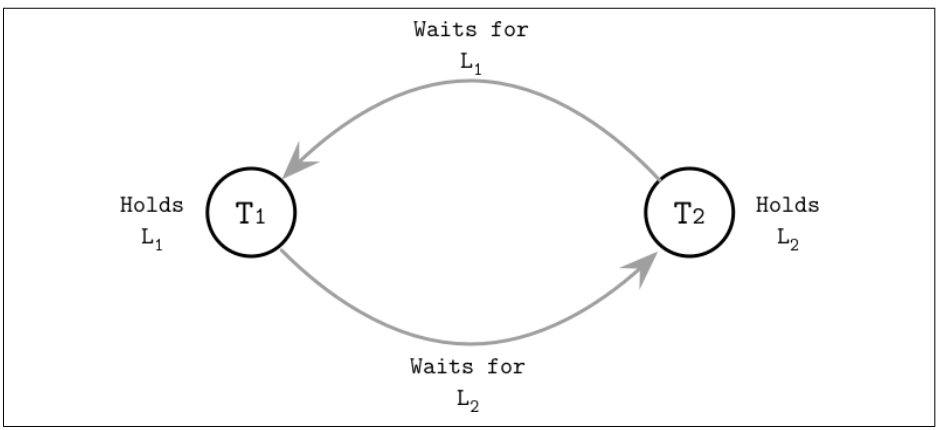

The simplest way to handle deadlocks is to introduce **timeouts** and **abort longrunning transactions** under the assumption that they might be in a deadlock. 

Another strategy, **conservative 2PL**, requires transactions to acquire all the locks before they can execute any of their operations and abort if they cannot. However, these approaches significantly limit system concurrency, and database systems mostly use a transaction manager to detect or avoid (in other words, prevent) deadlocks.

Detecting deadlocks is generally done using a **waits-for graph**, which tracks relationships between the in-flight transactions and establishes waits-for relationships between them. **Cycles** in this graph indicate the presence of a deadlock: transaction $T_1$ is waiting for $T_2$ which, in turn, waits for $T_1$. 

Deadlock detection can be done **periodically** (once per time interval) or **continuously** (every time the waits-for graph is updated). One of the transactions (usually, the one that attempted to acquire the lock more recently) is aborted.

To avoid deadlocks and restrict lock acquisition to cases that will not result in a deadlock, the transaction manager can use transaction timestamps to determine their priority. A lower timestamp usually implies higher priority and vice versa.

If transaction $T_1$ attempts to acquire a lock currently held by $T_2$, and $T_1$ has higher priority (it started before $T_2$), we can use one of the following restrictions to avoid deadlocks:
* **Wait-die** $T_1$ is allowed to block and wait for the lock. Otherwise, $T_1$ is aborted and restarted. In other words, a transaction can be blocked only by a transaction with a higher timestamp.
* **Wound-wait** $T_2$ is aborted and restarted ($T_1$ wounds $T_2$). Otherwise (if $T_2$ has started before $T_1$), $T_1$ is allowed to wait. In other words, a transaction can be blocked only by a transaction with a lower timestamp.

Transaction processing requires a scheduler to handle deadlocks. At the same time, **latches** rely on the programmer to ensure that deadlocks cannot happen and do not rely on deadlock avoidance mechanisms.

**Locks**


If two transactions are submitted concurrently, modifying overlapping segments of data, neither one of them should observe **partial results** of the other one, hence maintaining logical consistency. Similarly, two threads from the same transaction have to observe the same database contents, and have access to each other’s data. 

In transaction processing, there’s a distinction between the mechanisms that guard the logical and physical data integrity. The two concepts responsible logical and physical integrity are, correspondingly, locks and latches. The naming is somewhat unfortunate since **what’s called a latch here is usually referred to as a lock in systems programming**, but we’ll clarify the distinction and implications.

**Locks** are used to isolate and schedule overlapping transactions and manage database contents but not the internal storage structure, and are acquired on the key. Locks can guard either a specific key (whether it’s existing or nonexisting) or a range of keys. 

Locks are generally stored and managed outside of the tree implementation and represent a higher-level concept, managed by the database lock manager. Locks are more heavyweight than latches and are held for the duration of the transaction.

**Latches**


On the other hand, latches guard the physical representation: leaf page contents are modified during insert, update, and delete operations. Nonleaf page contents and a tree structure are modified during operations resulting in splits and merges that propagate from leaf under- and overflows. 

**Latches** guard the physical tree representation (page contents and the tree structure) during these operations and are obtained on the page level. Any page has to be latched to allow safe concurrent access to it.

Lockless concurrency control techniques still have to use latches.

Since a single modification on the leaf level might propagate to higher levels of the BTree, latches might have to be obtained on multiple levels. Executing queries should not be able to observe pages in an inconsistent state, such as incomplete writes or partial node splits, during which data might be present in both the source and target node, or not yet propagated to the parent.

The same rules apply to parent or sibling pointer updates. A general rule is to hold a latch for the smallest possible duration—namely, when the page is read or updated to increase concurrency.

Interferences between concurrent operations can be roughly grouped into three
categories:
* Concurrent reads, when several threads access the same page without modifying
it.
* Concurrent updates, when several threads attempt to make modifications to the
same page.
* Reading while writing, when one of the threads is trying to modify the page contents, and the other one is trying to access the same page for a read.

These scenarios also apply to accesses that overlap with database maintenance.

**Readers-writer lock**


The simplest latch implementation would grant exclusive read/write access to the
requesting thread. However, most of the time, we do not need to isolate all the processes from each other. 

For example, reads can access pages concurrently without causing any trouble, so we only need to make sure that multiple concurrent writers do not overlap, and readers do not overlap with writers. 

To achieve this level of granularity, we can use a readers-writer lock or RW lock. An RW lock allows multiple readers to access the object concurrently, and only writers (which we usually have fewer of) have to obtain exclusive access to the object.

|$~$|Reader|Writer|
|---|---|---|
|Reader|Shared|Exclusive|
|Writer|Exclusive|Exclusive|



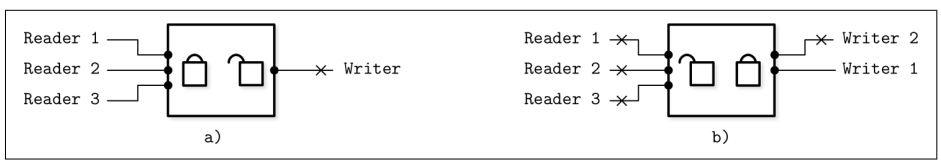

Since two overlapping reads attempting to access the same page do not require synchronization other than preventing the page from being fetched from disk by the page cache twice, reads can be safely executed concurrently in shared mode. As soon as writes come into play, we need to isolate them from both concurrent reads and other writes.

**Busy-Wait and Queueing Techniques**

To manage shared access to pages, we can either use blocking algorithms, which deschedule threads and wake them up as soon as they can proceed, or use busy-wait algorithms. 

Busy-wait algorithms allow threads to wait for insignificant amounts of time instead of handing control back to the scheduler. 

Queuing is usually implemented using **compare-and-swap** instructions, used to perform operations guaranteeing lock acquisition and queue update atomicity. If the queue is empty, the thread obtains access immediately. Otherwise, the thread appends itself to the waiting queue and spins on the variable that can be updated only by the thread preceding it in the queue. This helps to reduce the amount of CPU traffic for lock acquisition and release.

**Latch crabbing**

The most straightforward approach for latch acquisition is to grab all the latches on the way from the root to the target leaf. This creates a concurrency bottleneck and can be avoided in most cases. The time during which a latch is held should be minimized. 

One of the optimizations that can be used to achieve that is called **latch crabbing** (or **latch coupling**). Latch crabbing is a rather simple method that allows holding latches for less time and releasing them as soon as it’s clear that the executing operation does not require them anymore. On the read path, as soon as the child node is located and its latch is acquired, the parent node’s latch can be released.

During **insert**, the parent latch can be **released** if the operation is guaranteed **not** to result in **structural changes** that can propagate to it. In other words, the parent latch can be released if the **child node is not full**.

Similarly, during **deletes**, if the child node **holds enough elements** and the operation will not cause sibling nodes to merge, the latch on the parent node is released.

* a) The write latch is acquired on the root level.


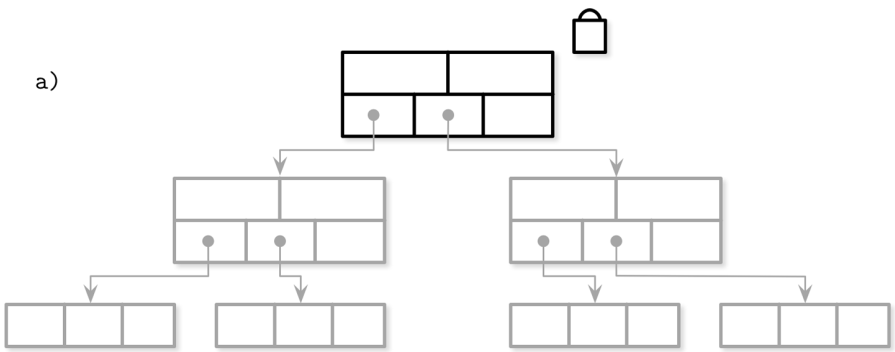

* b) The next-level node is located, and its write latch is acquired. The node is checked for potential structural changes. Since the node is not full, the parent latch can be released.


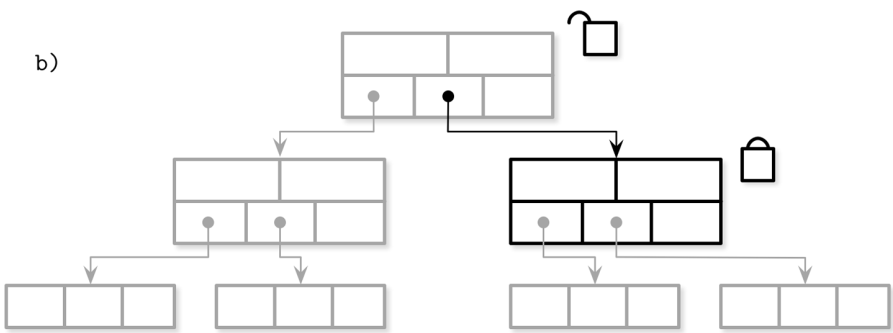

* c) The operation descends to the next level. The write latch is acquired, the target leaf node is checked for potential structural changes, and the parent latch is released.



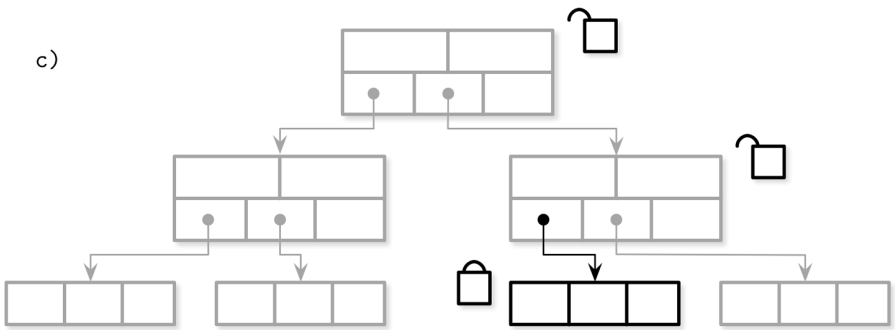

This approach is optimistic: most insert and delete operations do not cause structural changes that propagate multiple levels up. In fact, the probability of structural changes decreases at higher levels. 

Most of the operations only require the latch on the target node, and the number of cases when the parent latch has to be retained is relatively small.

If the child page is still not loaded in the page cache, we can either latch a future loading page, or release a parent latch and restart the root-to-leaf pass after the page is loaded to reduce contention. Restarting root-to-leaf traversal sounds rather expensive, but in reality, we have to perform it rather infrequently, and can employ mechanisms to detect whether or not there were any structural changes at higher levels since the time of traversal.

**Latch Upgrading and Pointer Chasing**


Instead of acquiring latches during traversal in an exclusive mode right away, **latch upgrading** can be employed instead. This approach involves acquisition of **shared locks** along the search path and upgrading them to **exclusive locks** when necessary.

* shared lock = read lock - you can read locked data, but not write
* exclusive lock - no reads or writes

Write operations first acquire **exclusive** locks **only at the leaf level**. If the leaf has to be split or merged, the algorithm walks up the tree and **attempts** to upgrade a shared lock that the parent holds, acquiring exclusive ownership of latches for the affected portion of the tree (i.e., nodes that will also be split or merged as a result of that operation). Since multiple threads might attempt to acquire exclusive locks on one of the
higher levels, one of them has to wait or restart.

You might have noticed that the mechanisms described so far all start by acquiring a latch on the **root node**. Every request has to go through the root node, and it quickly becomes a bottleneck. At the same time, the root is always the last to be split, since all of its children have to fill up first. This means that the root node can always be latched optimistically, and the price of a retry (pointer chasing) is seldom paid.

**$\text{B}^\text{link}$-Trees**

Every node but root in a $\text{B}^\text{link}$ has two pointers: 
* a child pointer descending from the parent and 
* a sibling link from the left node residing on the same level.

Blink-Trees allow a state called **half-split**, where the node is already referenced by the sibling pointer, but not by the child pointer from its parent. Half-split is identified by checking the node high key. If the search key exceeds the high key of the node (which violates the high key invariant), the lookup algorithm concludes that the structure has been changed concurrently and follows the sibling link to proceed with the search.

The pointer has to be quickly added to the parent guarantee the best performance, but the search process doesn’t have to be aborted and restarted, since all elements in the tree are accessible. The advantage here is that we do not have to hold the parent lock when descending to the child level, even if the child is going to be split: we can make a new node visible through its sibling link and update the parent pointer lazily without sacrificing correctness.

While this is slightly less efficient than descending directly from the parent and requires accessing an extra page, this results in correct root-to-leaf descent while simplifying concurrent access. Since splits are a relatively infrequent operation and BTrees rarely shrink, this case is exceptional, and its cost is insignificant. 

This approach has quite a few benefits: it reduces contention, prevents holding a parent lock during splits, and reduces the number of locks held during tree structure modification to a constant number. More importantly, it allows reads concurrent to structural tree changes, and prevents deadlocks otherwise resulting from concurrent modifications ascending to the parent nodes.